In [3]:
# !unzip '/content/drive/My Drive/classification/archive.zip'

!unzip '/content/drive/My Drive/new hope classification/train_tp'
!unzip '/content/drive/My Drive/new hope classification/train_fp1'
!unzip '/content/drive/My Drive/testing/test_tp0.2'
!unzip '/content/drive/My Drive/testing/test_fp0.2'


Streaming output truncated to the last 5000 lines.
  inflating: content/train_tp/tp_641.jpg  
  inflating: content/train_tp/tp_2168.jpg  
  inflating: content/train_tp/tp_2557.jpg  
  inflating: content/train_tp/tp_566.jpg  
  inflating: content/train_tp/tp_1423.jpg  
  inflating: content/train_tp/tp_666.jpg  
  inflating: content/train_tp/tp_2693.jpg  
  inflating: content/train_tp/tp_2948.jpg  
  inflating: content/train_tp/tp_1948.jpg  
  inflating: content/train_tp/tp_334.jpg  
  inflating: content/train_tp/tp_1488.jpg  
  inflating: content/train_tp/tp_1990.jpg  
  inflating: content/train_tp/tp_1557.jpg  
  inflating: content/train_tp/tp_183.jpg  
  inflating: content/train_tp/tp_2057.jpg  
  inflating: content/train_tp/tp_1728.jpg  
  inflating: content/train_tp/tp_3173.jpg  
  inflating: content/train_tp/tp_2395.jpg  
  inflating: content/train_tp/tp_449.jpg  
  inflating: content/train_tp/tp_1512.jpg  
  inflating: content/train_tp/tp_1095.jpg  
  inflating: content/train_tp/t

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import cv2
from PIL import Image
import numpy as np
np.random.seed(1000)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [ ]:
DATA_DIR = '/content/cell_images/cell_images/'
SIZE = 64
dataset = []
label = []

In [ ]:
parasitized_images = os.listdir(DATA_DIR + 'Parasitized/')
for i, image_name in enumerate(parasitized_images):
    try:
        if (image_name.split('.')[1] == 'png'):
            image = cv2.imread(DATA_DIR + 'Parasitized/' + image_name)
            image = Image.fromarray(image, 'RGB')
            image = image.resize((65, 65))
            dataset.append(np.array(image))
            label.append(0)
    except Exception:
        print("Could not read image {} with name {}".format(i, image_name))

In [ ]:
uninfected_images = os.listdir(DATA_DIR + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    try:
        if (image_name.split('.')[1] == 'png'):
            image = cv2.imread(DATA_DIR + 'Uninfected/' + image_name)
            image = Image.fromarray(image, 'RGB')
            image = image.resize((65, 65))
            dataset.append(np.array(image))
            label.append(1)
    except Exception:
        print("Could not read image {} with name {}".format(i, image_name))

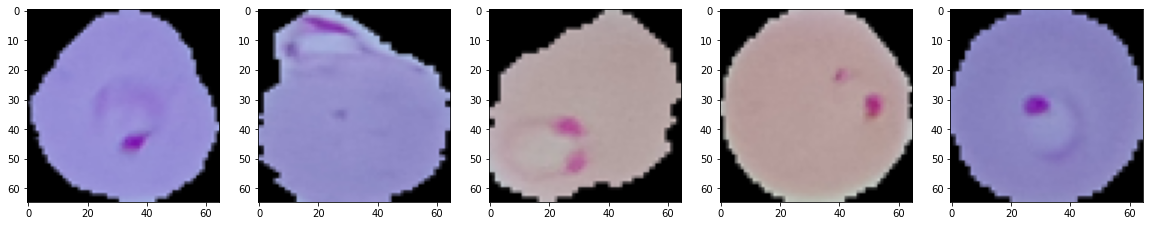

In [ ]:
plt.figure(figsize = (20, 12))
for index, image_index in enumerate(np.random.randint(len(parasitized_images), size = 5)):
    plt.subplot(1, 5, index+1)
    plt.imshow(dataset[image_index])

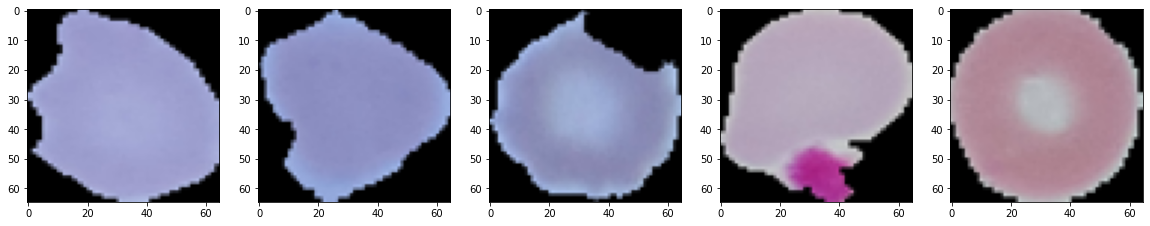

In [ ]:
plt.figure(figsize = (20, 12))
for index, image_index in enumerate(np.random.randint(len(uninfected_images), size = 5)):
    plt.subplot(1, 5, index+1)
    plt.imshow(dataset[len(parasitized_images) + image_index])

In [ ]:
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(label)), test_size = 0.20, random_state=1000)

In [ ]:
X_val = []
y_val = []

for i in range(len(X_train[17637:])):
    X_val.append(X_train[17637+i])
    y_val.append(y_train[17637+i])


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale = 1/255,
                                     zoom_range = 0.3,
                                     horizontal_flip = True,
                                     rotation_range = 30)

test_generator = ImageDataGenerator(rescale = 1/255)

train_generators = train_generator.flow(np.array(X_train),
                                       y_train,
                                       batch_size = 64,
                                       shuffle = False)

val_generator = train_generator.flow(np.array(X_val),
                                       y_val,
                                       batch_size = 64,
                                       shuffle = False)

test_generator = test_generator.flow(np.array(X_test),
                                     y_test,
                                     batch_size = 64,
                                     shuffle = False)

In [ ]:
import keras
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential

In [ ]:
classifier = Sequential()

classifier.add(Convolution2D(32, (3, 3), input_shape = (65, 65, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))

classifier.add(Dropout(0.2))

classifier.add(Convolution2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))

classifier.add(Dropout(0.2))

classifier.add(Convolution2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))

classifier.add(Dropout(0.2))

classifier.add(Flatten())
classifier.add(Dense(activation = 'relu', units=512))
classifier.add(BatchNormalization(axis = -1))

classifier.add(Dropout(0.2))

classifier.add(Dense(activation = 'relu', units=256))
classifier.add(BatchNormalization(axis = -1))

classifier.add(Dropout(0.2))

classifier.add(Dense(activation = 'sigmoid', units=2))


In [ ]:
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

history = classifier.fit_generator(train_generators,
                                   steps_per_epoch = len(X_train)/20,
                                   epochs = 50,
                                   shuffle = False,
                                   validation_data=val_generator,
                                   callbacks=[
                                   EarlyStopping(patience=5,restore_best_weights=True)])

In [ ]:
print("Test_Accuracy(after augmentation): {:.2f}%".format(classifier.evaluate_generator(test_generator, steps = len(X_test), verbose = 1)[1]*100))

537/537 [==============================] - 16s 29ms/step
Test_Accuracy(after augmentation): 70.94%


In [ ]:
classifier.save('malaria_weights.h5')

In [ ]:
classifier.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 63, 63, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 31, 31, 32)        128       
_________________________________________________________________
dropout_11 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 14, 14, 32)       

In [ ]:
# updating the weights for the new data 

In [13]:
import os
import cv2
import numpy as np

tp = 0
fp = 0
    
X_train = []
y_train = []
    
path = r'/content/content/train_tp'
    
for image in os.listdir(path):
    pic = cv2.imread(path+'/'+image)
    if np.shape(pic) != (65,65,3):
        pic = cv2.resize(pic, (65,65))
        X_train.append(pic)
        y_train.append(1)
        tp += 1
            
path = r'/content/content/train_fp'
    
for image in os.listdir(path):
        # print(image)
    pic = cv2.imread(path+'/'+image)
    if np.shape(pic) != (65,65,3):
        pic = cv2.resize(pic, (65,65))
        X_train.append(pic)
        y_train.append(0)
        fp += 1


print('train tp',tp)
print('train fp',fp)


tp = 0
fp = 0
X_test = []
y_test = []
    
path = r'/content/content/test_tp0.2'
    
for image in os.listdir(path):
    pic = cv2.imread(path+'/'+image)
    if np.shape(pic) != (65,65,3):
        pic = cv2.resize(pic, (65,65))
        X_test.append(pic)
        y_test.append(1)
        tp += 1
            
path = r'/content/content/test_fp0.2'
    
for image in os.listdir(path):
    pic = cv2.imread(path+'/'+image)
    if np.shape(pic) != (65,65,3):
        pic = cv2.resize(pic, (65,65))
        X_test.append(pic)
        y_test.append(0)
        fp += 1


print('test tp',tp)
print('test fp',fp)


train tp 3115
train fp 3712
test tp 320
test fp 217


In [6]:
from keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(X_train, to_categorical(np.array(y_train)), test_size = 0.10, random_state=1000)

Using TensorFlow backend.


In [14]:
from keras.utils import to_categorical

X_tests, _, y_tests, _ = train_test_split(X_test, to_categorical(np.array(y_test)), test_size = 0.00000010)

In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale = 1/255,
                                     zoom_range = 0.3,
                                     horizontal_flip = True,
                                     rotation_range = 30)


train_generators = train_generator.flow(np.array(X_train),
                                       y_train,
                                       batch_size = 20,
                                       shuffle = False)

val_generator = train_generator.flow(np.array(X_val),
                                       y_val,
                                       batch_size = 20,
                                       shuffle = False)


test_generator = ImageDataGenerator(rescale = 1/255,
                                     zoom_range = 0.3,
                                     horizontal_flip = True,
                                     rotation_range = 30)

test_generator = test_generator.flow(np.array(X_tests),
                                     y_tests,
                                     batch_size = 20,
                                     shuffle = False)

In [ ]:
from keras.models import load_model

classifier = load_model('/content/malaria_weights.h5')

In [ ]:
for layer in classifier.layers[:4]:
    print(layer.name)
    layer.trainable = False

conv2d_1
max_pooling2d_1
batch_normalization_1
dropout_1


In [17]:
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 63, 63, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)       

In [ ]:
classifier.save('motisis_model074.h5')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

classifier.fit_generator(train_generators,
                          steps_per_epoch = len(X_train)/20,
                          epochs = 50,
                          shuffle = False,
                          validation_data= val_generator,
                          callbacks=[
                              EarlyStopping(patience=5,restore_best_weights=True)]
                         )

In [ ]:
print("Test_Accuracy(after augmentation): {:.2f}%".format(classifier.evaluate_generator(test_generator, steps = len(y_tests), verbose = 1)[1]*100))                                    

536/536 [==============================] - 15s 28ms/step
Test_Accuracy(after augmentation): 71.45%


In [16]:
from keras.models import load_model

classifier = load_model('/content/motisis_model.h5')

In [62]:
predictions = classifier.predict(test_generator)

In [182]:
'''
Calculate F-score
'''

count = 0
total = 0
correct = 0

tp= 0
fp=0
fn=0
tn=0


for i in range(len(y_tests)):

    if predictions[i][0] < predictions[i][1] and y_tests[i][0] == 1.:
        fp += 1
    elif predictions[i][0] > predictions[i][1] and y_tests[i][0] == 0.:
        fn += 1
    elif predictions[i][0] < predictions[i][1] and y_tests[i][0] == 0.:
        tp += 1

    total += 1

print('tp: ',tp)
print('fp: ',fp)
print('fn: ',fn)

print('tp+fn: ', tp+fn)
Precision = tp/(tp+fp)
Recall = tp/(tp+fn)

f_score = (2 * Precision * Recall) / (Precision + Recall)


print('Precision: ',Precision)
print('Recall: ',Recall)
print('f_score: ',f_score)

tp:  240
fp:  56
fn:  79
tp+fn:  319
Precision:  0.8108108108108109
Recall:  0.7523510971786834
f_score:  0.7804878048780488


In [184]:
'''
Calculate F-score
'''

count = 0
total = 0
correct = 0

tp= 0
fp=0
fn=0
tn=0


for i in range(len(y_tests)):

    if predictions[i][0] > predictions[i][1] and y_tests[i][0] == 1.:
        tp += 1
    elif predictions[i][0] < predictions[i][1] and y_tests[i][0] == 1.:
        fn += 1
    elif predictions[i][0] > predictions[i][1] and y_tests[i][0] == 0.:
        fp += 1

    total += 1

print('tp: ',tp)
print('fp: ',fp)
print('fn: ',fn)


print('tp+fn: ', tp+fn)
Precision = tp/(tp+fp)
Recall = tp/(tp+fn)

f_score = (2 * Precision * Recall) / (Precision + Recall)


print('Precision: ',Precision)
print('Recall: ',Recall)
print('f_score: ',f_score)

tp:  161
fp:  79
fn:  56
tp+fn:  217
Precision:  0.6708333333333333
Recall:  0.7419354838709677
f_score:  0.7045951859956237


In [ ]:
# Confusion Matrix
[161 56
 79  240]

    precision    recall  f1-score   support

0       0.67      0.74      0.70       217
1       0.81      0.75      0.78       319  